In [78]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [79]:
def return_result_files_from_dir(directory: str):
    results_dir = Path(directory)

    if not results_dir.is_dir():
        print(f"Error: Directory '{directory}' not found.")
        return

    json_files = list(results_dir.glob('*_summary.json'))
    
    if not json_files:
        print(f"No summary JSON files (*_summary.json) found in '{directory}'.")
        return

    print(f"Found {len(json_files)} simulation result files.")
    return json_files

def to_float(value):
    return float(value) if isinstance(value, (int, float)) else None

## Análise de eficiência e escalabilidade

Referências:

1. "Practical Byzantine Fault Tolerance" (Castro e Liskov, 1999), Este é o artigo fundamental que introduziu o PBFT, o algoritmo do qual o sistema deriva.

2. "A Survey on Consensus Algorithms in Blockchain and Distributed Systems" (P. Singh et al., 2023) ou "Blockchains and Distributed Ledgers: Mathematics, Technology, and Economics" (A. Lipton, A. Treccani, 2021)

In [80]:

def gather_latency_results(directory: str):
    latency_values = []
    json_files = return_result_files_from_dir(directory)
    for file_path in json_files:
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                
                sp = data.get('simulation_parameters', {})
                op = data.get('overall_performance', {})
                
                rounds_completed = op.get('consensus_rounds_completed_with_decision')
                clock_time = op.get('simulation_wall_clock_time_seconds')
                throughput = round(rounds_completed / clock_time, 4)
                
                if op["consensus_rounds_completed_with_decision"] > 0:
                    avg_msgs_per_round = op["total_messages_exchanged"] / op["consensus_rounds_completed_with_decision"]
                else:
                    avg_msgs_per_round = 0
                    
                metrics = {
                    'latency': to_float(op.get('average_consensus_time_seconds')),
                    'num_groups': sp.get("num_groups"),
                    'num_drones_per_group': sp.get("num_drones_per_group"),
                    'throughput': throughput,
                    'avg_msgs_per_round': avg_msgs_per_round
                }

                latency_values.append(metrics)
        except Exception as e:
            print(f"Could not process {file_path.name}: {e}")

    if not latency_values:
        print("No data could be loaded for analysis.")
        return
    
    return latency_values

### Variação no número de grupos (10 drones / grupo)

In [81]:
data = gather_latency_results("simulation_results/latency/groups")
df = pd.DataFrame(data).sort_values(by='num_groups')
df.head()

Found 100 simulation result files.


,latency,num_groups,num_drones_per_group,throughput,avg_msgs_per_round
0,1.1056,1,10,1.3766,29.571429
97,0.9689,1,10,1.1776,28.250000
92,1.6503,1,10,1.3739,29.642857
87,1.1717,1,10,1.3752,28.214286
78,0.8959,1,10,1.3875,28.142857


In [82]:
aggregated_results = df.groupby('num_groups').agg(
    mean_latency=('latency', 'mean'),
    mean_throughput=('throughput', 'mean'),
    mean_avg_msgs_per_round=('avg_msgs_per_round', 'mean'),
)
aggregated_results.head(10)

,mean_latency,mean_throughput,mean_avg_msgs_per_round
num_groups,,,
1,1.093455,1.295118,28.748066
2,1.026756,2.416389,28.439461
3,1.299009,3.753991,28.874372
4,1.092690,4.920440,28.953068
5,1.137420,5.982430,28.978833
6,1.138810,7.341650,28.888098
7,1.143230,8.333330,28.694601
8,1.215060,9.567240,28.859262
9,1.105080,10.631390,28.992320


#### Latência

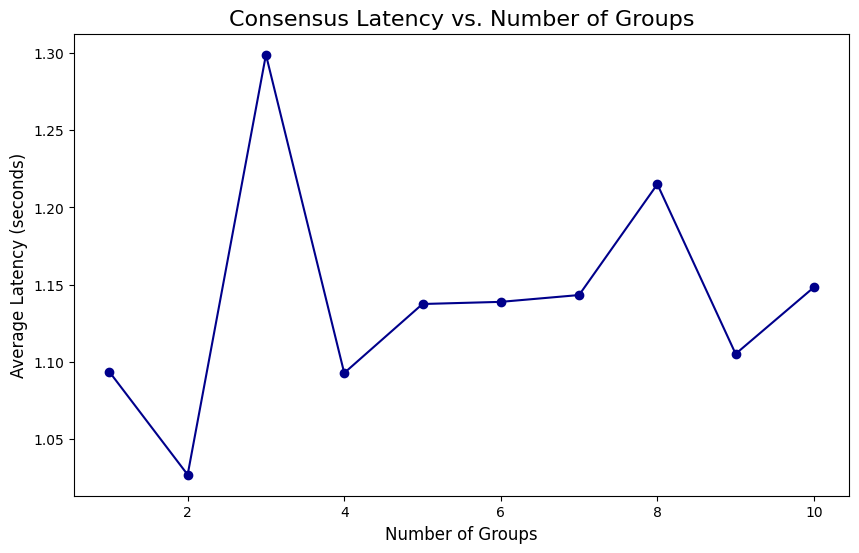

In [83]:
plt.figure(figsize=(10, 6))
plt.plot(
    aggregated_results.index, 
    aggregated_results['mean_latency'],
    marker='o', 
    linestyle='-', 
    color='darkblue'
)
plt.title('Consensus Latency vs. Number of Groups', fontsize=16)
plt.xlabel('Number of Groups', fontsize=12)
plt.ylabel('Average Latency (seconds)', fontsize=12)
plt.show()

#### Throughput

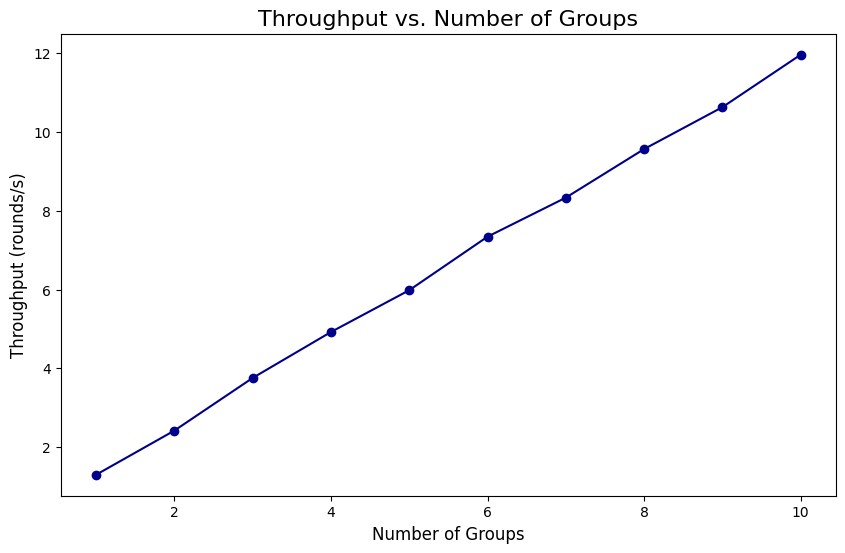

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(
    aggregated_results.index, 
    aggregated_results['mean_throughput'],
    marker='o', 
    linestyle='-', 
    color='darkblue'
)
plt.title('Throughput vs. Number of Groups', fontsize=16)
plt.xlabel('Number of Groups', fontsize=12)
plt.ylabel('Throughput (rounds/s)', fontsize=12)
plt.show()

#### Overhead de comunicação

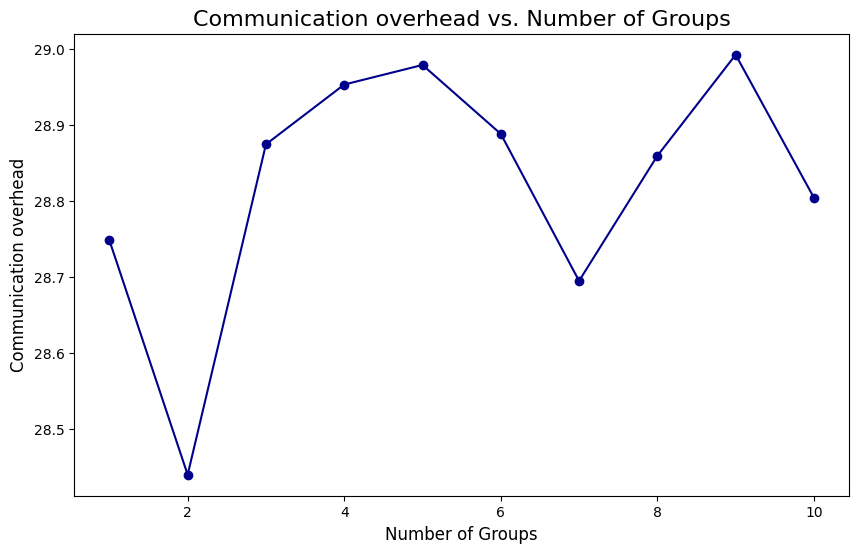

In [85]:
plt.figure(figsize=(10, 6))
plt.plot(
    aggregated_results.index, 
    aggregated_results['mean_avg_msgs_per_round'],
    marker='o', 
    linestyle='-', 
    color='darkblue'
)
plt.title('Communication overhead vs. Number of Groups', fontsize=16)
plt.xlabel('Number of Groups', fontsize=12)
plt.ylabel('Communication overhead', fontsize=12)
plt.show()

### Variação no número de drones por grupo (5 grupos)

In [86]:
data = gather_latency_results("simulation_results/latency/drones_per_group")
df = pd.DataFrame(data).sort_values(by='num_drones_per_group')
df.head()

Found 60 simulation result files.


,latency,num_groups,num_drones_per_group,throughput,avg_msgs_per_round
39,0.6971,5,5,8.2434,13.238095
3,0.7818,5,5,7.5099,13.526316
27,0.5842,5,5,8.3252,13.141176
54,0.7201,5,5,9.0020,13.043478
26,0.7345,5,5,7.8201,13.362500


In [87]:
aggregated_results = df.groupby('num_drones_per_group').agg(
    mean_latency=('latency', 'mean'),
    mean_throughput=('throughput', 'mean'),
    mean_avg_msgs_per_round=('avg_msgs_per_round', 'mean'),
)
aggregated_results.head(10)

,mean_latency,mean_throughput,mean_avg_msgs_per_round
num_drones_per_group,,,
5,0.65639,8.15287,13.242974
10,1.06912,6.11737,28.830214
15,1.31773,4.65433,45.034147
20,1.99507,3.63685,61.911439
25,2.68334,2.94954,78.986613
30,3.08447,2.40101,98.358769


#### Latência

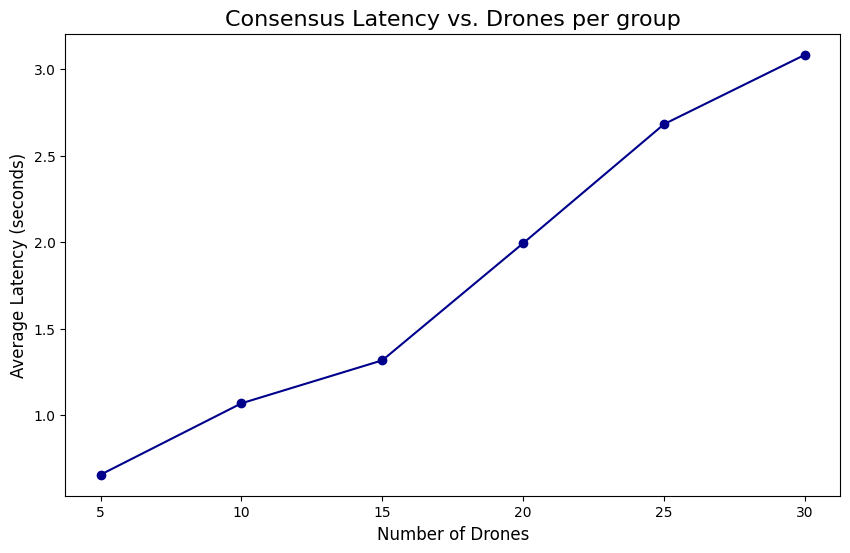

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(
    aggregated_results.index, 
    aggregated_results['mean_latency'], 
    marker='o',
    linestyle='-', 
    color='darkblue'
)
plt.title('Consensus Latency vs. Drones per group', fontsize=16)
plt.xlabel('Number of Drones', fontsize=12)
plt.ylabel('Average Latency (seconds)', fontsize=12)
plt.show()

#### Throughput

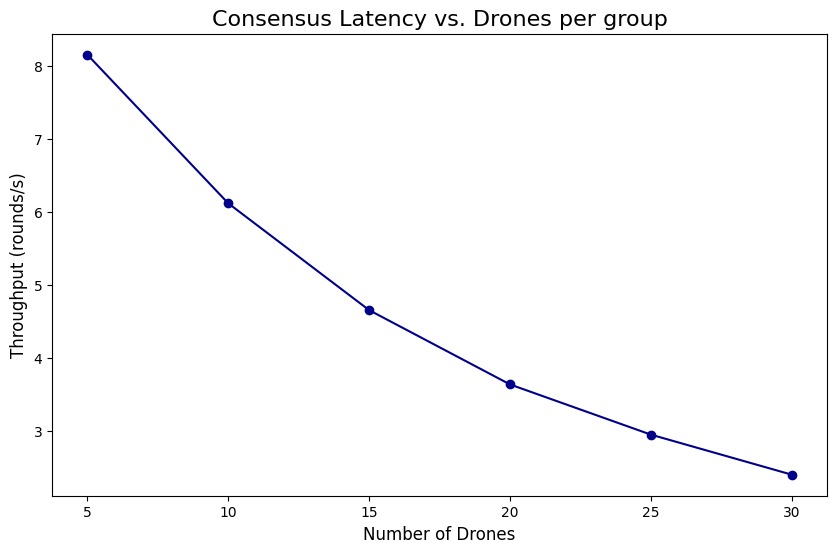

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(
    aggregated_results.index, 
    aggregated_results['mean_throughput'], 
    marker='o', 
    linestyle='-', 
    color='darkblue'
)
plt.title('Consensus Latency vs. Drones per group', fontsize=16)
plt.xlabel('Number of Drones', fontsize=12)
plt.ylabel('Throughput (rounds/s)', fontsize=12)
plt.show()

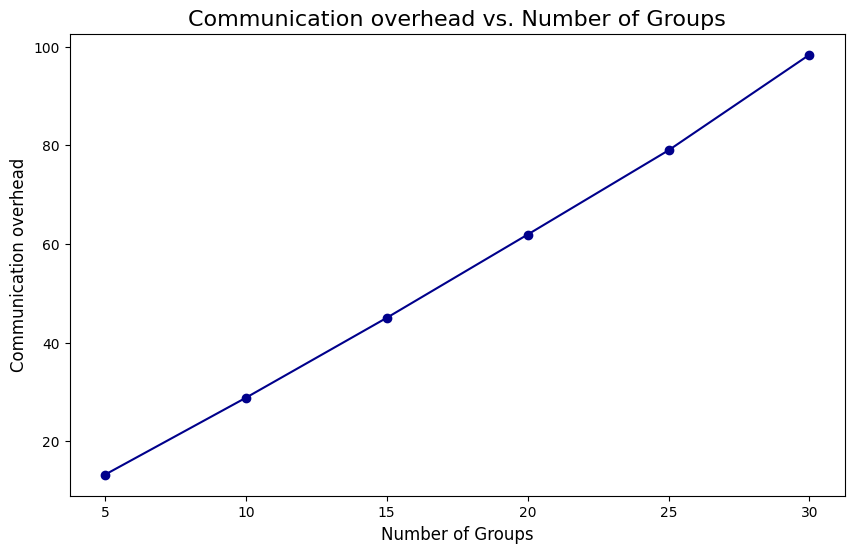

In [97]:
plt.figure(figsize=(10, 6))
plt.plot(
    aggregated_results.index, 
    aggregated_results['mean_avg_msgs_per_round'],
    marker='o', 
    linestyle='-', 
    color='darkblue'
)
plt.title('Communication overhead vs. Number of Groups', fontsize=16)
plt.xlabel('Number of Groups', fontsize=12)
plt.ylabel('Communication overhead', fontsize=12)
plt.show()

## Tolerância a falhas

Serão realizadas 100 execuções de 10 segundos contendo 5 grupos de 10 drones para verificação das métricas

In [90]:

def gather_fault_tolerance_results(directory: str):
    latency_values = []
    json_files = return_result_files_from_dir(directory)
    for file_path in json_files:
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)

                latency_values.append(data.get('validation_metrics', {}))
        except Exception as e:
            print(f"Could not process {file_path.name}: {e}")

    if not latency_values:
        print("No data could be loaded for analysis.")
        return
    
    return latency_values

In [91]:
ft_values = gather_fault_tolerance_results("simulation_results/fault_tolerance")
df = pd.DataFrame(ft_values)
df.head()

Found 100 simulation result files.


,true_positives,false_positives,true_negatives,false_negatives,accuracy,precision,recall,specificity
0,34,2,10,11,0.7719,0.9444,0.7556,0.8333
1,26,1,15,18,0.6833,0.9630,0.5909,0.9375
2,31,0,16,21,0.6912,1.0000,0.5962,1.0000
3,28,1,12,14,0.7273,0.9655,0.6667,0.9231
4,40,1,5,15,0.7377,0.9756,0.7273,0.8333


In [92]:
results = df.mean()

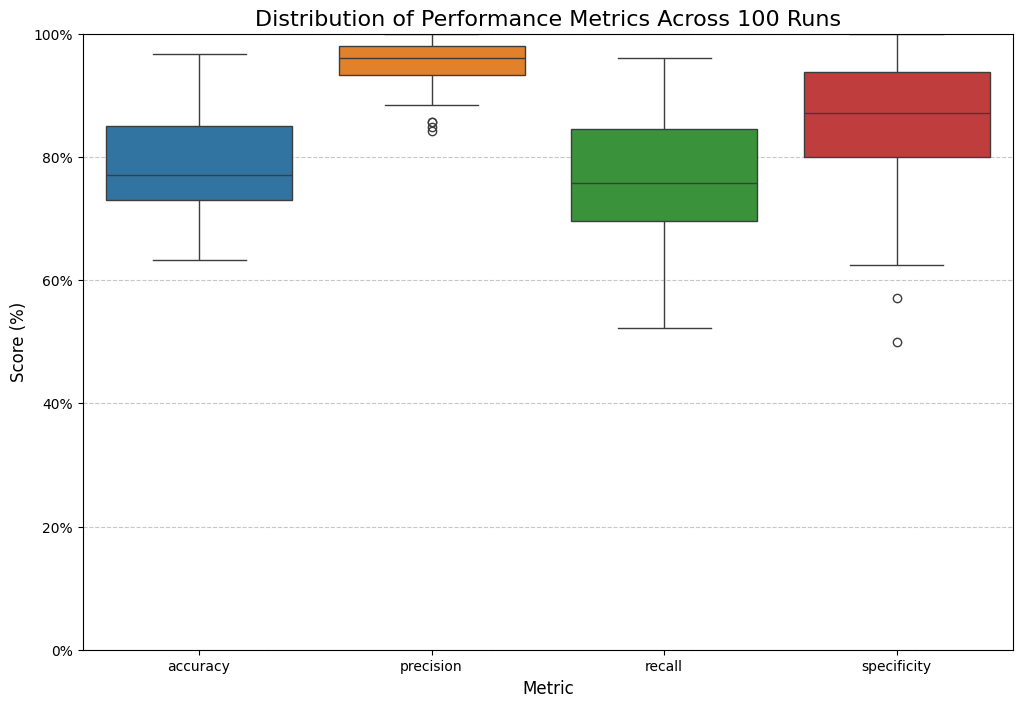

In [93]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[['accuracy', 'precision', 'recall', 'specificity']])

plt.title('Distribution of Performance Metrics Across 100 Runs', fontsize=16)
plt.ylabel('Score (%)', fontsize=12)
plt.xlabel('Metric', fontsize=12)

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [94]:
results[['accuracy', 'precision', 'recall', 'specificity']]

accuracy       0.784821
precision      0.956439
recall         0.763022
specificity    0.862879
dtype: float64

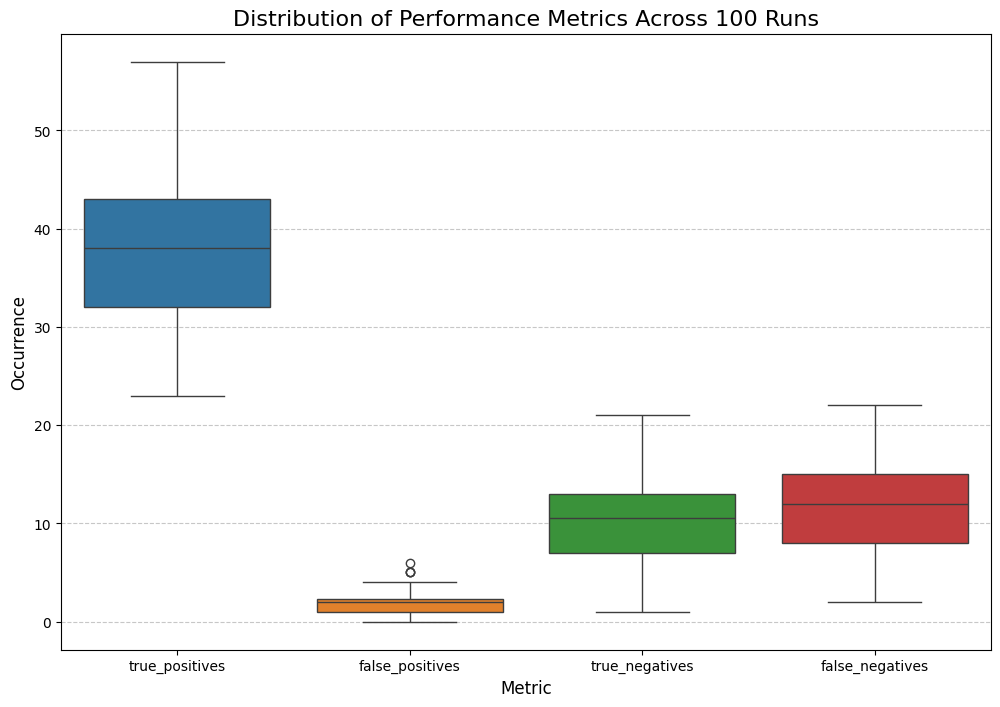

In [95]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[['true_positives', 'false_positives', 'true_negatives', 'false_negatives']])

plt.title('Distribution of Performance Metrics Across 100 Runs', fontsize=16)
plt.ylabel('Occurrence', fontsize=12)
plt.xlabel('Metric', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

In [96]:
results[['true_positives', 'false_positives', 'true_negatives', 'false_negatives']]

true_positives     37.60
false_positives     1.65
true_negatives     10.42
false_negatives    11.55
dtype: float64